# QTT Demo
###### # Author: Suhan Shetty, suhan.shetty@idiap.ch | suhan.n.shetty@gmail.com

In [1]:
import torch
#!pip install tntorch # if you dont have tntorch
import tntorch as tnt 

/Users/sshetty/miniconda3/envs/pyml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define your scalar valued function

In [2]:
# Define your scalar function
def scalar_fcn(x): 
    # input shape,  x: batch x 1
    # ouptut shape, y: batch x 1
    return (x**2).view(-1) + torch.cos(2*torch.pi*x)

### Define utility functions

In [3]:
# Utility functions
def domain2idx(x, domain):
    '''
        Input: x in interval [a,b], (shape: batch x 1)
        Output: the corresponding index I in range (0, n-1), (shape: batch x 1)
        domain: discretization tensor (e.g, torch.linspace(a,b,n))
            where interval [a,b] is assumed to be discretized into n points 
            (note: n = 2^K, for some K>0)
    '''

    n = len(domain)
    y = torch.clip(x, domain[0],domain[-1]).view(-1)
    I = torch.clip(((y.view(-1,1)- domain.view(1,-1))>=0).sum(dim=-1)-1, 0,  len(domain)-2)
    #I = torch.argmin(torch.abs(x[:,i].view(-1,1)- domain[i]), dim=1) 
    return I


def idx2domain(I, domain): 
    '''
        Output: x in interval [a,b], (shape: batch x 1)
        Input: the corresponding index I in range (0, n-1), (shape: batch x 1)
        domain: discretization tensor (e.g, torch.linspace(a,b,n))
            where interval [a,b] is assumed to be discretized into n points 
            (note: n = 2^K, for some K>0)
    '''
    x = torch.zeros(len(I.view(-1)))
    x =  domain[I.view(-1)]
    return x.view(-1) 


def dec2binary(I, K):
    '''
        I: integer representing the discretization of the domain [a,b], shape: (batch x 1 )
        K (number of bits): represents number discretization (note: n = 2^K, for some K>0)
            (or its the length of the binary string representation)
        return binary string of length K
    '''
    mask = 2**torch.arange(K).to(I.dtype)
    return I.unsqueeze(-1).bitwise_and(mask).ne(0).byte().flip(dims=(1,)).long()


def bin2dec(I_binary):
    # return decimal
    # I_binary: binary tensor
    K = I_binary.shape[-1] # K: number of bits
    mask = 2 ** torch.arange(K - 1, -1, -1).to(I_binary.dtype)
    return torch.sum(mask * I_binary, -1)



# # Evaluate elements of QTT model
# def get_qtt_value(tt_model, idx_binary):
#     '''
#     Given the tt_model and a batch of index (binary idx) get the  elements
#     '''
#     tt_cores = tt_model.tt().cores
#     mat_ = tt_cores[0][:,idx_binary[:,0].view(-1),:]
#     for i in range(1,idx_binary.shape[-1]):
#         mat_ = torch.einsum('ijk,kjl->ijl',(mat_,tt_cores[i][:,idx_binary[:,i]]))
#     return mat_.view(-1)

def get_tt_value(tt_model, x,  domain, K, spline_type='linear'):
    '''
        Given the qtt_model and the points from the domain
    '''
    tt_cores = tt_model.tt().cores[:]
    n_discretization = len(domain)
    idx_1 = domain2idx(x, domain).view(-1)
    idx_2 = idx_1 + 1 
    x_1 = idx2domain(idx_1,domain).view(-1)
    x_2 = idx2domain(idx_2,domain).view(-1)
    idx_binary_1 = dec2binary(idx_1, K)
    idx_binary_2 = dec2binary(idx_2, K)
    dx = (x-x_1)/(1e-9+ (x_2-x_1))
    mat_ = tt_cores[0][:,idx_binary_1[:,0],:]+dx.view(1,-1,1)*(tt_cores[0][:,idx_binary_2[:,0],:]-tt_cores[0][:,idx_binary_1[:,0],:])
    for i in range(1,idx_binary_1.shape[-1]):
        mat = tt_cores[i][:,idx_binary_1[:,i],:]+dx.view(1,-1,1)*(tt_cores[i][:,idx_binary_2[:,i],:]-tt_cores[i][:,idx_binary_1[:,i],:])
        mat_ = torch.einsum('ijk,kjl->ijl',mat_,mat)
    return mat_.view(-1)


### Fit QTT model

In [4]:
# Define the number of binary bits for QTT representation
K = 8
n = 2**K # number of discretization
print(f"Number of bits for quantization :{K}, num discretization:{n}")

Number of bits for quantization :8, num discretization:256


In [5]:
# Cross approximation hyperparams
max_qtt_rank = 10
num_tt_cross_iterations  = 100
desired_accuracy = 1e-3

In [6]:
# Find the QTT model
domain = torch.linspace(-1,1,n) #domain of the function 
domain_qtt = [torch.tensor([0,1])]*K

# The corresponding qtt function
def quantized_scalar_fcn(I_binary): 
    # I_binary: binary representation
    I_dec = bin2dec(I_binary).long()
    x = idx2domain(I_dec, domain)
    return scalar_fcn(x).view(-1)

# cross approximation to find the QTT model
qtt_model = tnt.cross(quantized_scalar_fcn,
                        domain=domain_qtt,
                        max_iter=num_tt_cross_iterations, 
                        eps=desired_accuracy, 
                        rmax=max_qtt_rank, 
                        kickrank=5, 
                        function_arg='matrix',
                        device="cpu",
                        _minimize=False,
                        val_size=1000,
                          verbose=True)


cross device is cpu
Cross-approximation over a 8D domain containing 256 grid points:
iter: 0   | eps: 8.445e-01 | time:   0.0167 | largest rank:   1
iter: 1   | eps: 4.950e-07 | time:   0.0518 | largest rank:   6 <- converged: eps < 0.001
Did 586 function evaluations, which took 0.004783s (1.225e+05 evals/s)



In [7]:
print("Rank of the QTT model: ", [core.shape[1] for core in qtt_model.tt().cores])
def get_num_params_tt(tt_model):
    m = 0
    for core in tt_model.tt().cores[:]:
        m = m + core.shape[0]*core.shape[1]*core.shape[2]
    return m
num_tt_params = get_num_params_tt(qtt_model)
print("Number of parameters in QTT model: ", num_tt_params)


Rank of the QTT model:  [2, 2, 2, 2, 2, 2, 2, 2]
Number of parameters in QTT model:  280


In [8]:
# Procedure to retrieve values from QTT model
def get_model_value(x):
    # x: a batch of points from the domain of the scalar_fcn()
    # uses linear interpolation
    return get_tt_value(tt_model=qtt_model, x=x, domain=domain, K=K) 

### Test QTT model

In [9]:
# Test points
x = torch.linspace(-1,1,100) # from domain
y_true = scalar_fcn(x)
y_qtt = get_model_value(x)


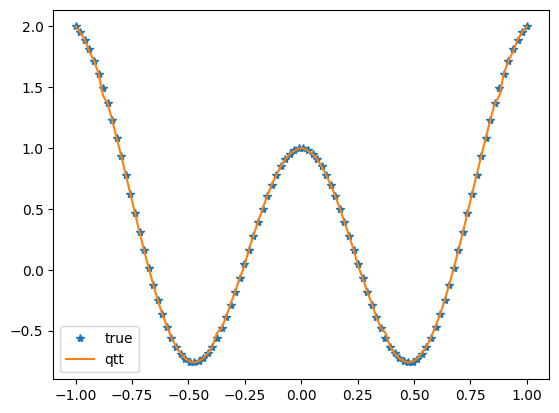

In [10]:
import matplotlib.pyplot as plt
plt.plot(x, y_true, '*', label='true')
plt.plot(x, y_qtt, '-', label='qtt')
plt.legend()


In [11]:
# Sanity check of utility functions

# Evaluate your function


# # index of the discretization point (0, n-1)
# I_left = domain2idx(x, domain)
# I_right = I_left + 1

# # binary qauntization
# Ib_left = dec2binary(I_left, K)
# Ib_right = dec2binary(I_right, K)

# # Get back the index for sanity check
# Idec_left = bin2dec(Ib_left)
# Idec_right = bin2dec(Ib_right)

# #Evaluate the qtt function
# y_left = quantized_scalar_fcn(Ib_left)
# y_right = quantized_scalar_fcn(Ib_right)

# y_qtt_left = get_qtt_value(qtt_model, Ib_left)
# y_qtt_right = get_qtt_value(qtt_model, Ib_right)